In [1]:
# Update the Make and model information here. 
# Note that this value has to be case sensitive and should match as it shows in donedeal.ie
# Note that beyond XC90 others will also be suggested.
make = 'Volvo'
model = 'XC90'


# Geocoding API Details. For distance calculation
# Requires an account in https://geocode.maps.co, free for personal use. Follow information from the website
user_town = "Letterkenny"
user_county = "Donegal"
geocode_api_key=""
# Done Deal website details
url = 'https://www.donedeal.ie/cars'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

#Debugging
verbose = False

In [2]:
import json
import time
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime
from math import sin, cos, sqrt, atan2, radians

In [10]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [11]:
def print_msg(msg):
    if verbose == True:
        print(msg)

def geocoding_url_builder(town, county):
    geocoding_url = f"https://geocode.maps.co/search?q={','.join([town,county])}&api_key={geocode_api_key}"
    return geocoding_url

cache = {}
def location_to_coords(town, county):
    if town == None:
        town = ''
    if county == None:
        county = ''
    key = town.lower()+'#'+county.lower()
    if cache.get(key) != None:
        print_msg(f"Returning from cache {key}")
        return cache[key]
    response = requests.get(geocoding_url_builder(town, county))
    time.sleep(1) # The API cannot be hit more than once a second :-(
    if response.text is None or len(response.text) == 0:
        return -1
    json_body = json.loads(response.text)
    if len(json_body) == 0:
       return -1
    loc = json_body[0]["display_name"]
    # The API returns many results. The 0th one is reasonable and considered to be closest accurate
    lat = json_body[0]["lat"]
    lon = json_body[0]["lon"]
    cache[key] = (lat,lon)
    print_msg(f"Returning from geocoding api {key}")
    return lat, lon

#This should be retrieved from cache
user_lat, user_lon = location_to_coords(user_town, user_county)
# distance between two geo coordinates (radial distance, not driving distance)
def haversine(dealer_lat, dealer_lon):
    R = 6373.0
    lat1, lon1, lat2, lon2 = float(user_lat), float(user_lon), float(dealer_lat), float(dealer_lon)
    if lat1 == None or lat2 == None or lon1 == None or lon2 == None:
        return -1
    dlon = radians(lon2) - radians(lon1)
    dlat = radians(lat2) - radians(lat1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance



In [12]:
encoders = {}

def chilly_encode(source, key):
    if source is None or source == '':
        return -2147483647
    if key is None or key == '':
        return -1
    
    if encoders.get(source) == None:
        encoders[source] = {}

    if encoders[source].get(key) == None:
        encoders[source][key] = len(encoders[source]) + 1
    return  encoders[source][key]

In [46]:
class Ad:
    def is_related(ad):
        x = Ad.item(ad["displayAttributes"], "model")
        if x is None or x == '':
            return False
        if x.upper() == model.upper():
            return True
        return False
        
    def __init__(s, ad : dict): 
        def a(tag):
            return Ad.item(ad["displayAttributes"], tag)
        s.ad_id = ad.get("id")
        s.make = a("make").upper()
        s.model = a("model").upper()
        # Set the price based on GBP / EUR conversions
        s.price = s.get_price(ad.get("price"), ad.get("currency"))
        s.trim = s.process_trim(a("trim"))
        s.manufacture_year = a("year")
        s.mileage = s.process_mileage(a("mileage"))
        s.fuel_type = s.process_fuel_type(a("fuelType"))
        s.transmission = s.process_transmission(a("transmission"))
        s.body_type = a("bodyType")
        s.engine_size = s.process_engine(a("engine"))
        s.engine_power = s.process_engine_power(a("enginePower"))
        s.acceleration_0_to_100 = s.process_acceleration(a("acceleration"))
        s.seats = a("seats")
        s.imported = s.process_imported(a("countryOfPreviousRegistration"))
        s.past_owners = a("owners")
        s.road_tax = a("roadTax")
        s.nct = s.process_nct(a("NCT"))
        s.safety_rating = s.process_safety_rating(a("safetyRating"))
        s.warrenty = s.process_warrenty(a("warranty"))
        s.county = ad.get("county")
        s.town = ad.get("countyTown")
        s.distance_to_buy_in_km = s.process_distance(s.town, s.county)

    def item(attributes, tag):
        for item in attributes:
            if item["name"] == tag:
                return item["value"]
    
    def get_dict(s):
        return s.__dict__
        
    def process_warrenty(s, x):
        if x is None or x == '':
            return 0

        if "years" in x:
            x = x.replace("years", "")

        if "year" in x:
            x = x.replace("year", "")

        if " " in x:
            x = x.replace(" ", "")

        if x.isdigit():
            return int(x)
        else:
            return -1
    
    def process_trim(s, x):
        #y = chilly_encode("trim", x)
        return x
    
    def process_imported(s, x):
        #y = chilly_encode("imported", x)
        return x
    
    def process_distance(s, dealer_town, dealer_county):
        lat2, lon2 = location_to_coords(dealer_town, dealer_county)
        return haversine(lat2, lon2)
 
    def process_transmission(s, x):
        #y = chilly_encode("transmission", x)
        return x
    
    # Diesel = 1
    # Petrol = 2
    # Petrol Hybrid = 3
    # Petrol Plug-in Hybrid = 4
    # Electic = 5
    # Unknown = -1
    def process_fuel_type(s, x):
        if x is None or x == "":
            return "Unknown"
        x = x.lower()
        if "petrol" in x and "hybrid" in x and "plug" in x and "in" in x:
            return "Plugin-Hybrid-Petrol"
        if "petrol" in x and "hybrid" in x:
            return "Plugin-Hybrid-Petrol"
        if "diesel" in x:
            return "Diesel"
        if "petrol" in x:
            return "Petrol"
        if "electric" in x:
            return "Electric"
        return "Unknown"
    
    # mileage 0 - 10,000 km          = 1
    # mileage 10,000 - 50,000 km     = 2
    # mileage 50,000 - 100,000 km    = 3
    # mileage 100,000 - 200,000 km   = 4
    # mileage 200,000 - 300,000 km   = 5
    # mileage > 300,000  km          = 6
    def process_mileage(s, x):
        if x is None or x == '':
            return 0
        else: 
            x = x.replace(",", "")
            x = x.replace(" ", "")
            x = x.lower().replace("km", "")
            if "mi" in x or "mile" in x:
                x = x.replace("miles", "").replace("mile", "").replace("mi", "")
                try:
                    x = float(x) * 1.6
                except:
                    print(x)
            x = float(x)        
            return x
            
    def process_engine(s, x):
        if x is None or len(x) == 0:
            return x
        else:
            x = x.replace("L", "")
            x = x.replace(" ", "")
            return x

    def process_engine_power(s, x):
        if x is None or len(x) == 0:
            return x
        else:
            x = x.replace("hp", "")
            x = x.replace(" ", "")
            return x

    def process_acceleration(s, x):
        if x is None or len(x) == 0:
            return x
        else:
            x = x.replace("sec", "")
            x = x.replace(" ", "")
            return x

    def process_nct(s, x):
        if x is None or len(x) == 0:
            return -1 #TBD : See what makes sense for imputation
        else:
            return (datetime.strptime(x, '%b %Y') - datetime.today()).days
    
    def process_safety_rating(s, x):
        if x is None:
            return 3
        else:
            return x.split('/')[0]
    
    def get_price(x, price, curr):
        if price is None:
            return 0
        p = int(price.replace(',', ''))
        if curr == "GBP":
            p = p * 1.17 #based on 26 Mar 2024
        elif curr == "USD":
            p = p * 0.92 #based on 26 Mar 2024
        return p

In [14]:
page_cache = {}

In [47]:
next_from = 1
def get_page_contents(next_from):
    if page_cache.get(next_from) != None:
        return page_cache[next_from]
    params = f'start={next_from}&make={make}&model={model}'
    page = requests.get(f'{url}?{params}', headers = headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    contents = soup.find('script', id="__NEXT_DATA__")
    payload = json.loads(contents.get_text())
    payload = payload["props"]["pageProps"]
    page_cache[next_from] = payload
    return payload

# Some of the details below are specific to how the DoneDeal website is setup. It does web scraping
ads = []
while True:
    js = get_page_contents(next_from)
    total_pages = js["paging"]["totalPages"]
    print(f"Processing page {next_from} of {total_pages}")
    ads_json = js["ads"]
    for ad_json in ads_json:
        if Ad.is_related(ad_json):
            ad = Ad(ad_json)
            ads.append(ad.get_dict())
        
    if next_from == total_pages:
        break
    else:
        next_from = next_from + 1

Processing page 1 of 48
Processing page 2 of 48
Processing page 3 of 48
Processing page 4 of 48
Processing page 5 of 48
Processing page 6 of 48
Processing page 7 of 48
Processing page 8 of 48
Processing page 9 of 48
Processing page 10 of 48
Processing page 11 of 48
Processing page 12 of 48
Processing page 13 of 48
Processing page 14 of 48
Processing page 15 of 48
Processing page 16 of 48
Processing page 17 of 48
Processing page 18 of 48
Processing page 19 of 48
Processing page 20 of 48
Processing page 21 of 48
Processing page 22 of 48
Processing page 23 of 48
Processing page 24 of 48
Processing page 25 of 48
Processing page 26 of 48
Processing page 27 of 48
Processing page 28 of 48
Processing page 29 of 48
Processing page 30 of 48
Processing page 31 of 48
Processing page 32 of 48
Processing page 33 of 48
Processing page 34 of 48
Processing page 35 of 48
Processing page 36 of 48
Processing page 37 of 48
Processing page 38 of 48
Processing page 39 of 48
Processing page 40 of 48
Processin

In [52]:
df = pd.DataFrame(ads)
df = df[["price", "trim", "manufacture_year", "mileage", "fuel_type", "transmission", "seats", "past_owners"]]
df

,price,trim,manufacture_year,mileage,fuel_type,transmission,seats,past_owners
0,40000.0,R-Design,2018,139200.0,Diesel,Automatic,7,2
1,69995.0,Inscription,2020,76585.6,Diesel,Automatic,7,1
2,60950.0,R-Design,2020,75349.0,Plugin-Hybrid-Petrol,Automatic,7,1
3,40000.0,R-Design,2018,139200.0,Diesel,Automatic,7,2
4,69995.0,Inscription,2020,76585.6,Diesel,Automatic,7,1
...,...,...,...,...,...,...,...,...
182,99900.0,Plus,2024,0.0,Plugin-Hybrid-Petrol,Automatic,7,
183,105900.0,Ultimate,2024,0.0,Plugin-Hybrid-Petrol,Automatic,7,
184,75900.0,R-Design Pro,2021,74801.0,Plugin-Hybrid-Petrol,Automatic,7,1
185,56995.0,R-Design,2020,120000.0,Plugin-Hybrid-Petrol,Automatic,7,1


# Table of Contents
---

 * [Overview](#e42514e8-142b-4934-8310-c1ef29555a72)

	 * [Quick Info](#b0b59344-f1fc-4ca6-bb0d-b74b9365bb9d)

	 * [Data Types](#1302a680-1b76-41fe-b5e4-69eeac2ecc8d)

	 * [Data Preview](#e4eebe98-415b-47aa-a5e5-ab222714b133)

	 * [Missing Values](#b043538f-6320-4237-806d-49e8e85a47b2)

	 * [Rows With Missing Value](#0bfcd93c-8e52-4957-bc01-b00ef053149e)

	 * [Constant Occurrence](#ec126b9c-ba6a-4172-ae43-bd80d6e6976b)

	 * [Duplicate Rows](#f1efc235-6c33-4023-9ac4-6e7fa7fcc25b)

 * [Univariate Analysis](#4bd24c2a-03c4-4b60-9963-127faca90b65)

 * [Bivariate analysis](#b391a356-7202-484a-a5f8-a83505e7761a)

	 * [Correlation Plot](#96f1e4a6-7014-43b8-a6bd-1357b59bd4ff)

	 * [Pairplot](#3aad8831-3678-45dc-8533-963405148132)

	 * [Contingency table](#1552973e-0b78-47f9-8d43-f1eedc8c5bd6)

 * [Multivariate analysis](#1500a098-6b6e-4306-89fe-37a251b905c7)

	 * [Principal Component Analysis](#161c1db9-379d-4dda-9749-a9350f144ed0)

	 * [Parallel coordinates](#fc517a23-3541-44c9-bb1a-fc2080993014)

	 * [Parallel categories](#824d24b0-2a15-4a1d-a4e8-fd82edf224f9)


# Overview<a id='e42514e8-142b-4934-8310-c1ef29555a72'>
---

## Quick Info<a id='b0b59344-f1fc-4ca6-bb0d-b74b9365bb9d'>

,
Rows,187
Columns,8
Missing cells,0 (0.00 %)
Zeros,43 (2.87 %)
Duplicate rows,176 (94.12 %)


## Data Types<a id='1302a680-1b76-41fe-b5e4-69eeac2ecc8d'>

Column Name,Inferred Data Type
price,numeric
trim,categorical
manufacture_year,categorical
mileage,numeric
fuel_type,categorical
transmission,categorical
seats,categorical
past_owners,categorical


## Data Preview<a id='e4eebe98-415b-47aa-a5e5-ab222714b133'>

### First rows

,price,trim,manufacture_year,mileage,fuel_type,transmission,seats,past_owners
0,40000.0,R-Design,2018,139200.0,Diesel,Automatic,7,2
1,69995.0,Inscription,2020,76585.6,Diesel,Automatic,7,1
2,60950.0,R-Design,2020,75349.0,Plugin-Hybrid-Petrol,Automatic,7,1
3,40000.0,R-Design,2018,139200.0,Diesel,Automatic,7,2
4,69995.0,Inscription,2020,76585.6,Diesel,Automatic,7,1


### Last rows

,price,trim,manufacture_year,mileage,fuel_type,transmission,seats,past_owners
182,99900.0,Plus,2024,0.0,Plugin-Hybrid-Petrol,Automatic,7,
183,105900.0,Ultimate,2024,0.0,Plugin-Hybrid-Petrol,Automatic,7,
184,75900.0,R-Design Pro,2021,74801.0,Plugin-Hybrid-Petrol,Automatic,7,1
185,56995.0,R-Design,2020,120000.0,Plugin-Hybrid-Petrol,Automatic,7,1
186,53995.0,Momentum,2019,88000.0,Plugin-Hybrid-Petrol,Automatic,7,1


### Sample

,price,trim,manufacture_year,mileage,fuel_type,transmission,seats,past_owners
110,81950.0,Inscription Pro,2022,93053.0,Plugin-Hybrid-Petrol,Automatic,7,1
125,99900.0,Plus,2024,0.0,Plugin-Hybrid-Petrol,Automatic,7,
128,99900.0,Plus,2024,0.0,Plugin-Hybrid-Petrol,Automatic,7,
183,105900.0,Ultimate,2024,0.0,Plugin-Hybrid-Petrol,Automatic,7,
151,65900.0,R-Design,2021,41476.0,Plugin-Hybrid-Petrol,Automatic,7,1


## Missing Values<a id='b043538f-6320-4237-806d-49e8e85a47b2'>

There are no missing values


## Rows With Missing Value<a id='0bfcd93c-8e52-4957-bc01-b00ef053149e'>

There are no missing values


## Constant Occurrence<a id='ec126b9c-ba6a-4172-ae43-bd80d6e6976b'>

Column Name,0 Count,0 %
mileage,43,22.995
price,0,0.000
trim,0,0.000
manufacture_year,0,0.000
fuel_type,0,0.000
transmission,0,0.000
seats,0,0.000
past_owners,0,0.000


## Duplicate Rows<a id='f1efc235-6c33-4023-9ac4-6e7fa7fcc25b'>

,
Duplicate rows column subset,all columns
Duplicate row count,176
Duplicate row percentage,94.12 %


# Univariate Analysis<a id='4bd24c2a-03c4-4b60-9963-127faca90b65'>
---

## *price - numeric*

,
Number of unique values,11
Sum,12 602 560.0
Mean,67 393.37
Mode,16 789.50
Standard deviation,28 163.72
Mean absolute deviation,22 029.48
Median absolute deviation,14 556.63
Coefficient of variation,0.42
Kurtosis,-0.64
Skewness,-0.49


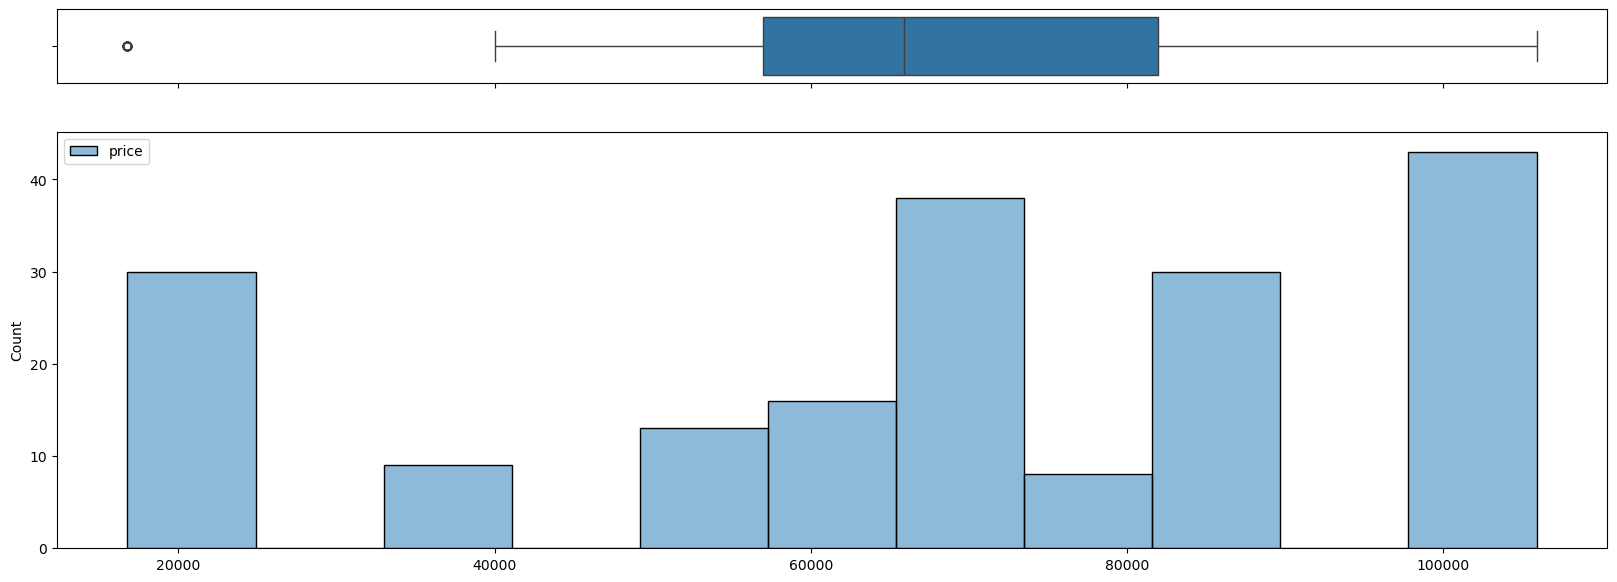

---

## *trim - categorical*

,
R-Design,58 (31.02 %)
Inscription Pro,30 (16.04 %)
,30 (16.04 %)
Plus,22 (11.76 %)
Ultimate,21 (11.23 %)
Other values count,26 (13.90 %)
Null,0 (0.00 %)


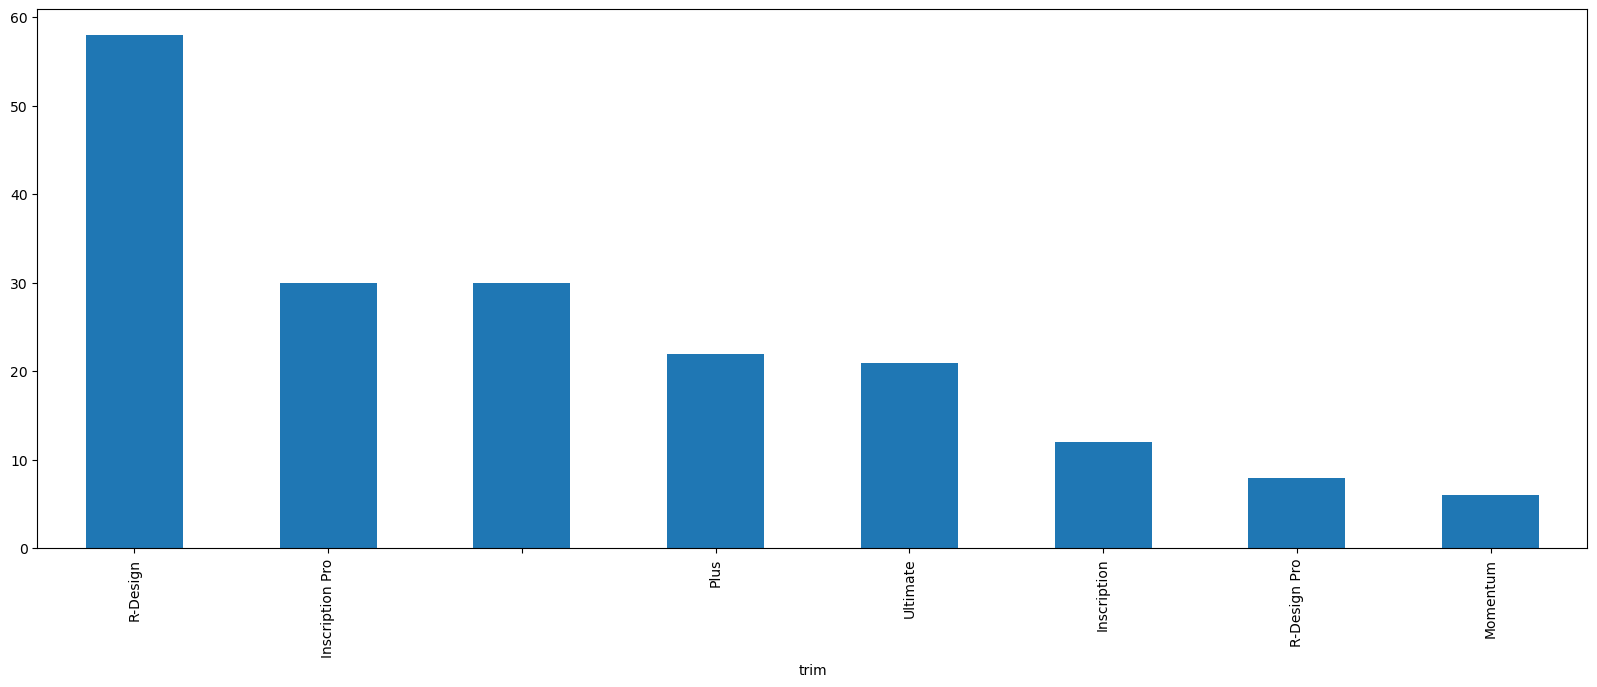

---

## *manufacture_year - categorical*

,
2024,43 (22.99 %)
2020,35 (18.72 %)
2021,34 (18.18 %)
2022,30 (16.04 %)
2015,30 (16.04 %)
Other values count,15 (8.02 %)
Null,0 (0.00 %)


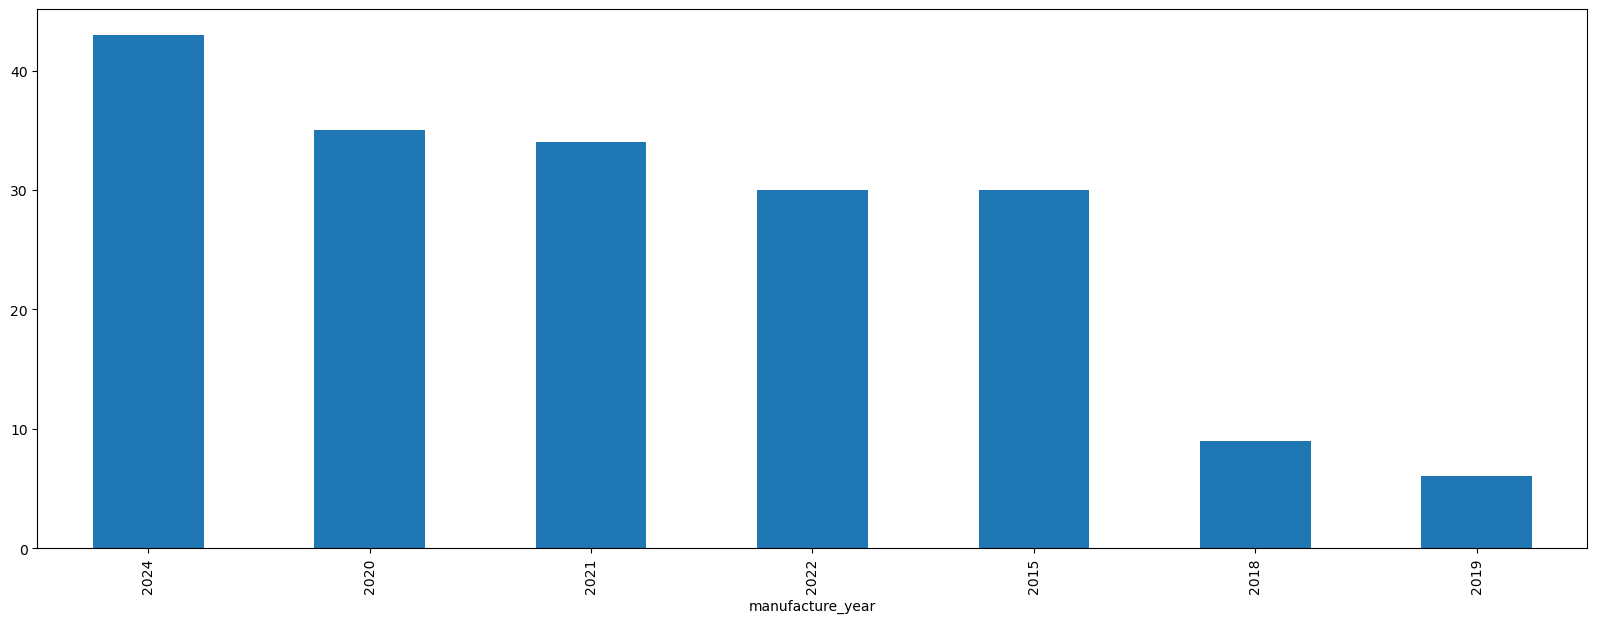

---

## *mileage - numeric*

,
Number of unique values,10
Sum,16 706 585.20
Mean,89 340.03
Mode,0.0
Standard deviation,80 688.12
Mean absolute deviation,59 757.73
Median absolute deviation,47 864.03
Coefficient of variation,0.90
Kurtosis,-0.09
Skewness,0.94


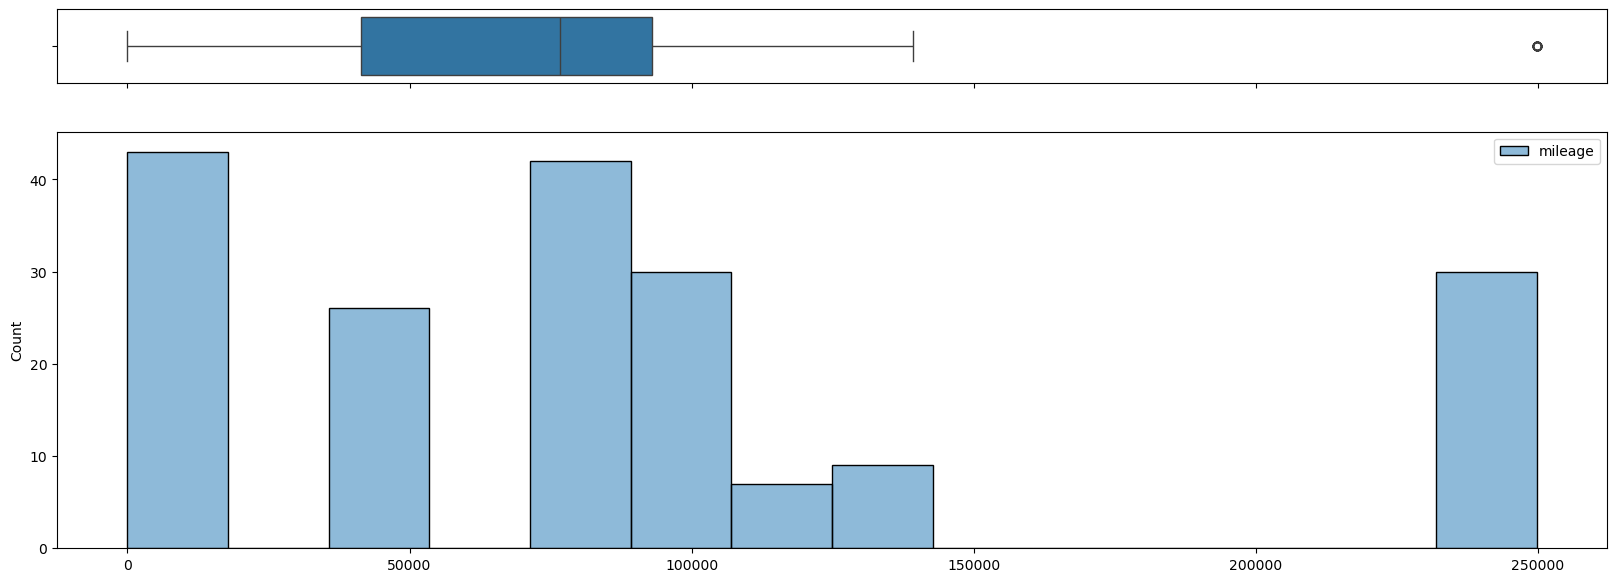

---

## *fuel_type - categorical*

,
Plugin-Hybrid-Petrol,136 (72.73 %)
Diesel,51 (27.27 %)
Other values count,0 (0.00 %)
Null,0 (0.00 %)


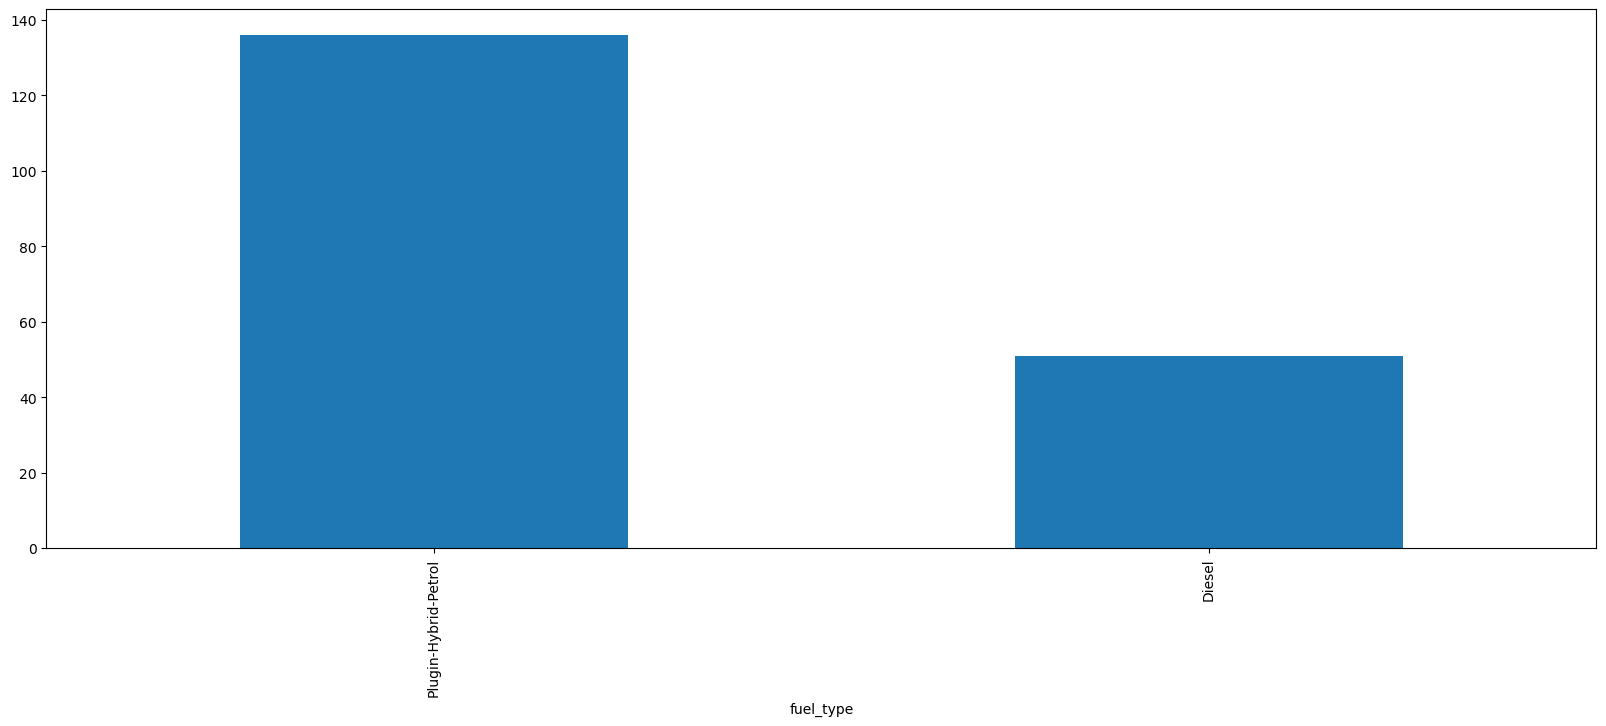

---

## *transmission - categorical*

,
Automatic,187 (100.00 %)
Other values count,0 (0.00 %)
Null,0 (0.00 %)


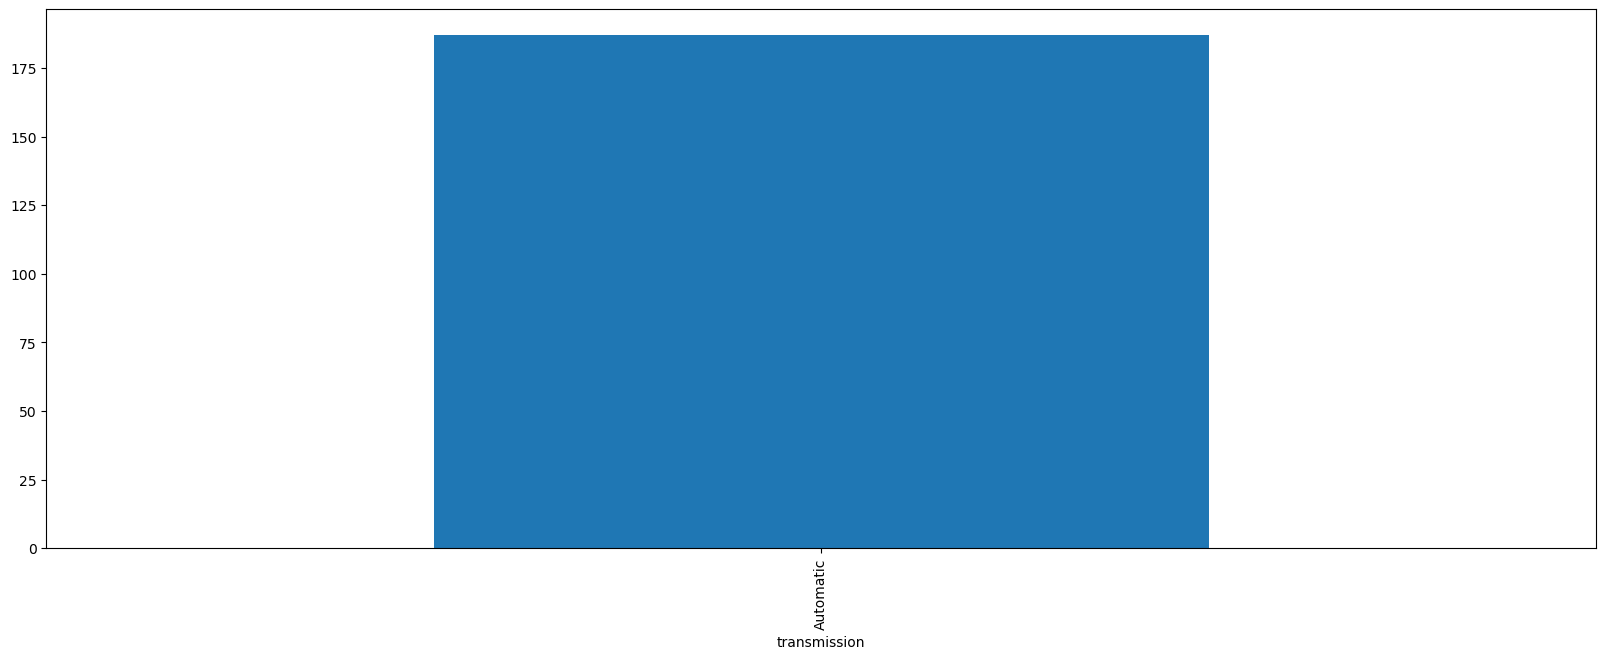

---

## *seats - categorical*

,
7,187 (100.00 %)
Other values count,0 (0.00 %)
Null,0 (0.00 %)


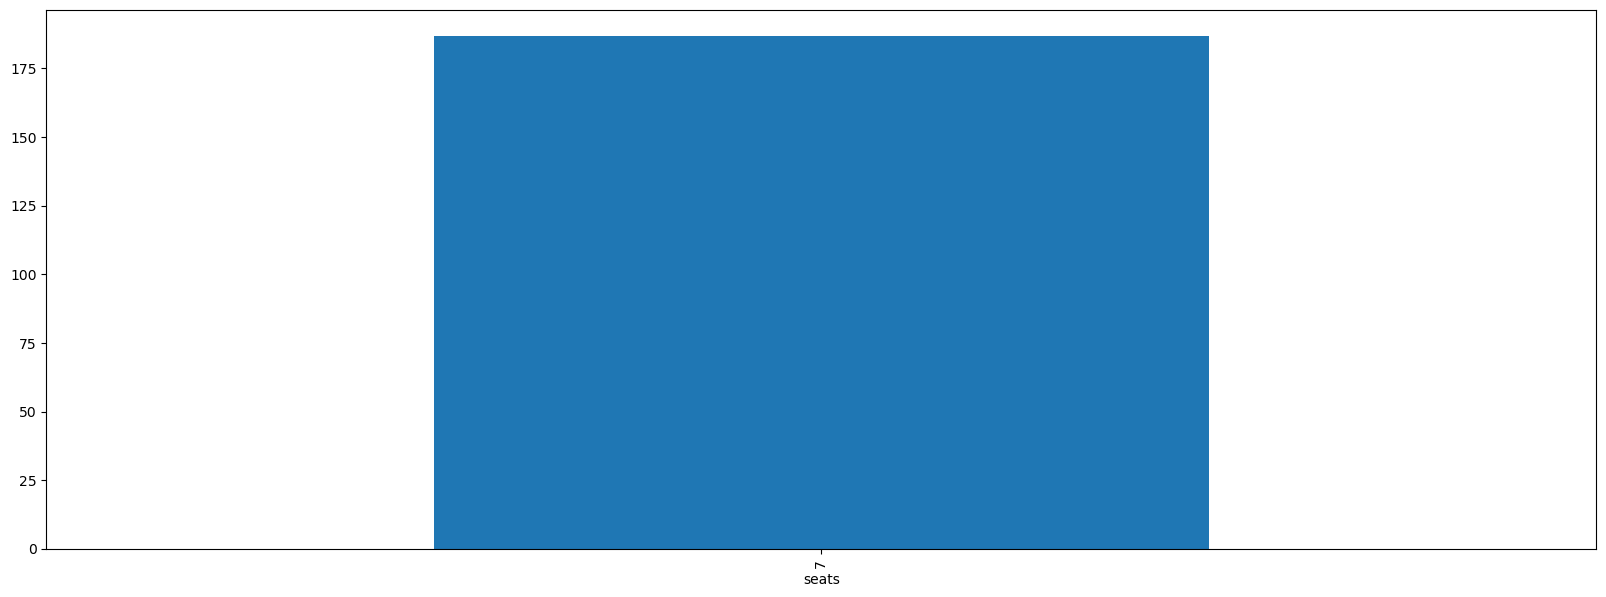

---

## *past_owners - categorical*

,
1,105 (56.15 %)
,43 (22.99 %)
4,30 (16.04 %)
2,9 (4.81 %)
Other values count,0 (0.00 %)
Null,0 (0.00 %)


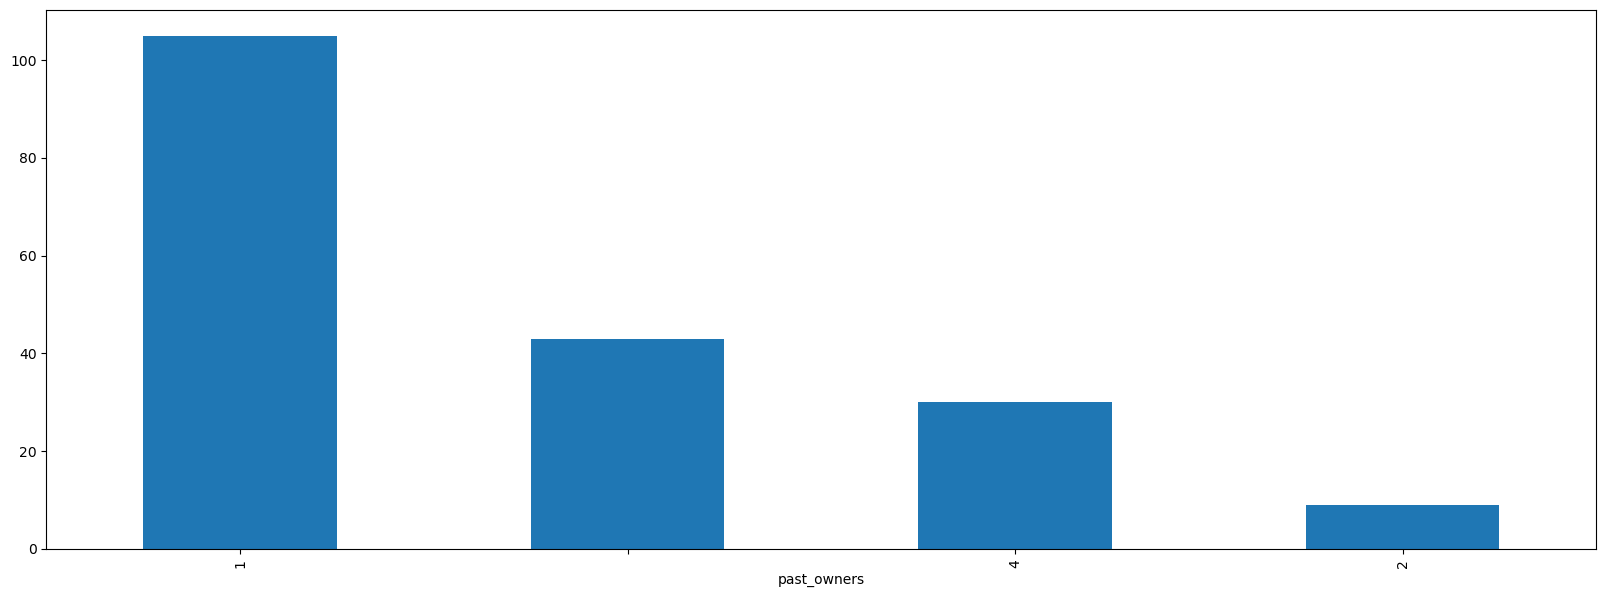

---

# Bivariate analysis<a id='b391a356-7202-484a-a5f8-a83505e7761a'>
---

## Correlation Plot<a id='96f1e4a6-7014-43b8-a6bd-1357b59bd4ff'>

### Pearson Correlation

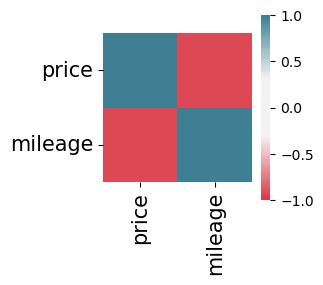

### Spearman Correlation

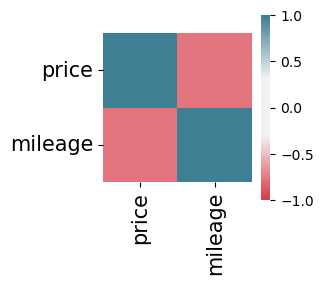

### Kendall Correlation

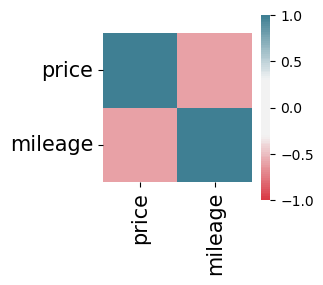

## Pairplot<a id='3aad8831-3678-45dc-8533-963405148132'>

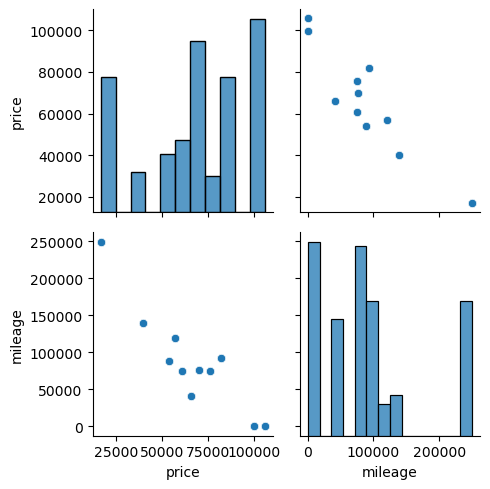

## Contingency table<a id='1552973e-0b78-47f9-8d43-f1eedc8c5bd6'>

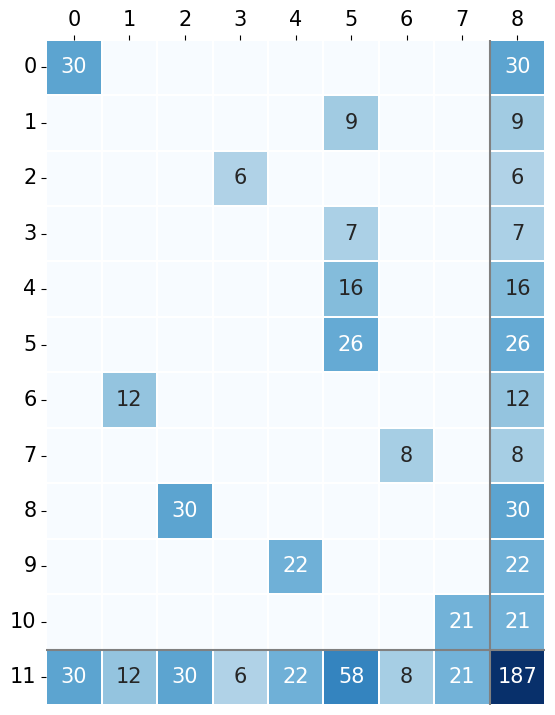

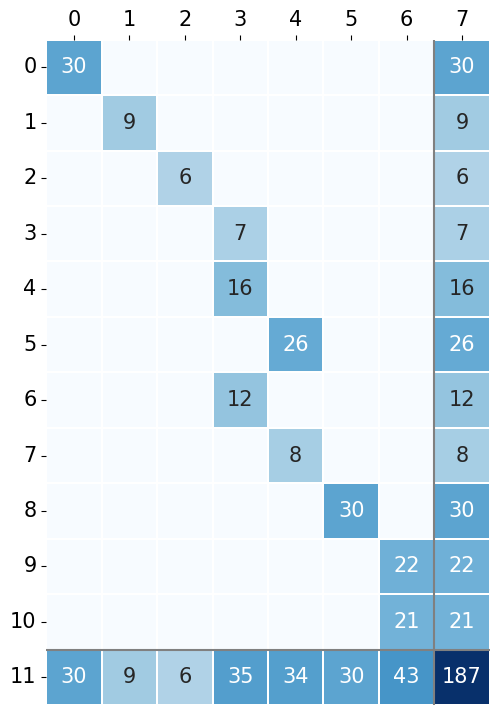

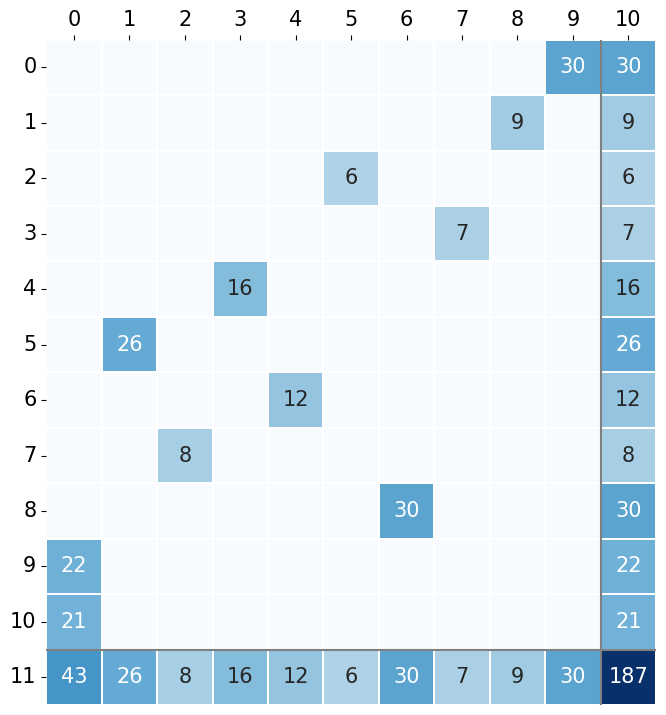

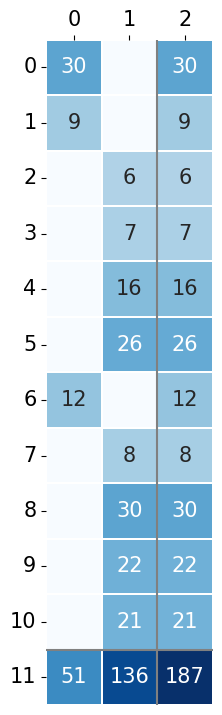

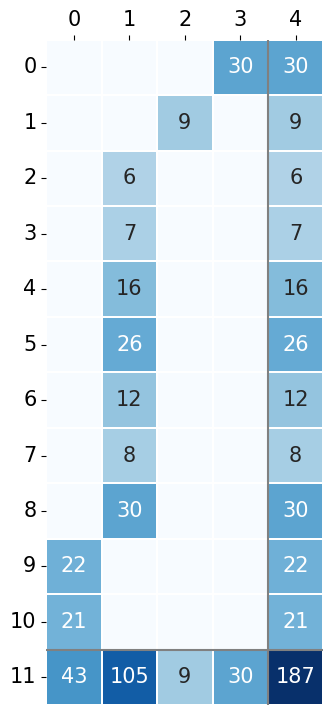

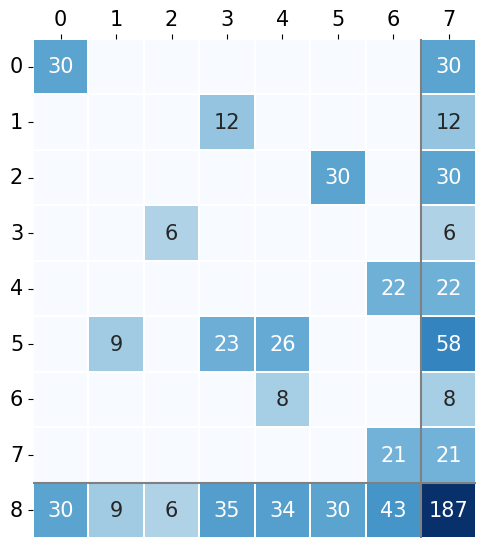

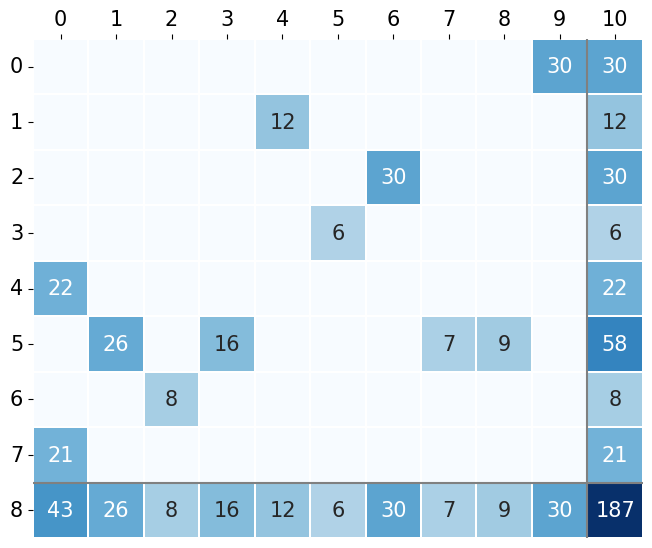

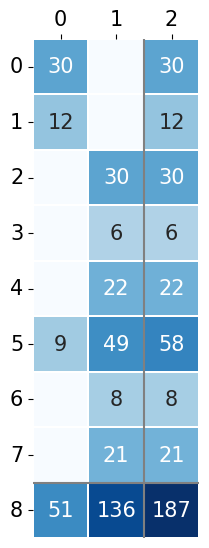

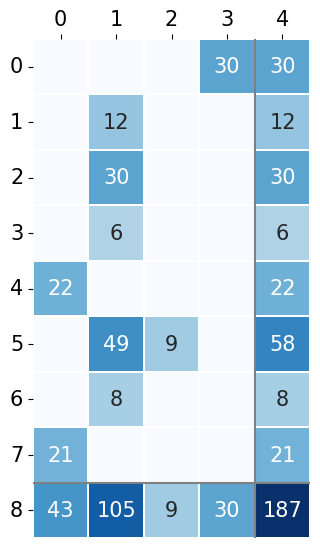

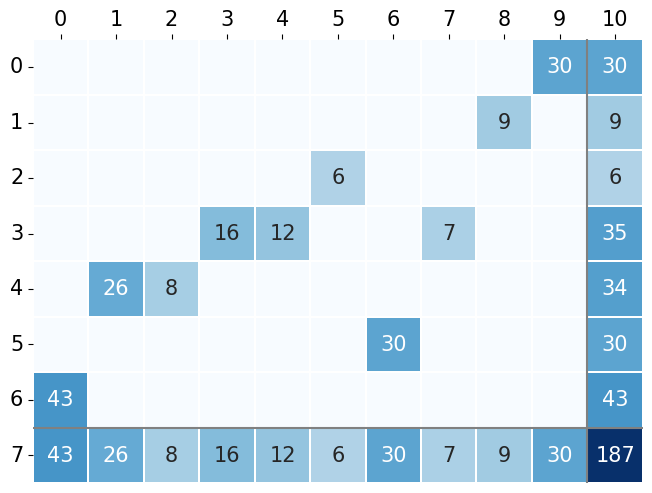

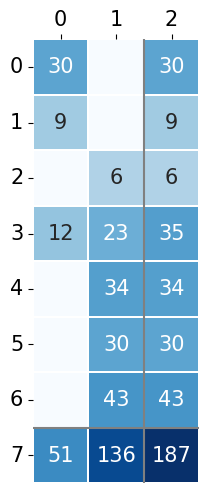

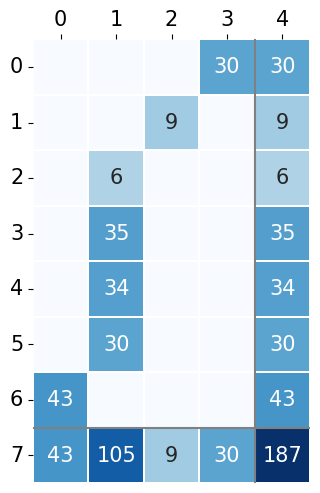

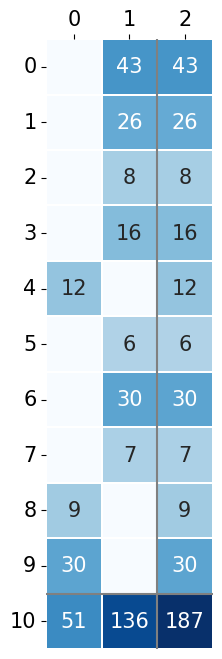

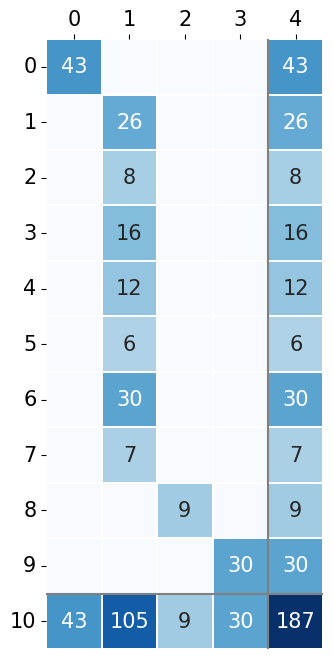

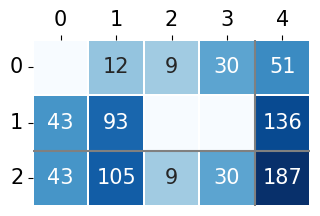

# Multivariate analysis<a id='1500a098-6b6e-4306-89fe-37a251b905c7'>
---

## Principal Component Analysis<a id='161c1db9-379d-4dda-9749-a9350f144ed0'>

### First vs second principal component

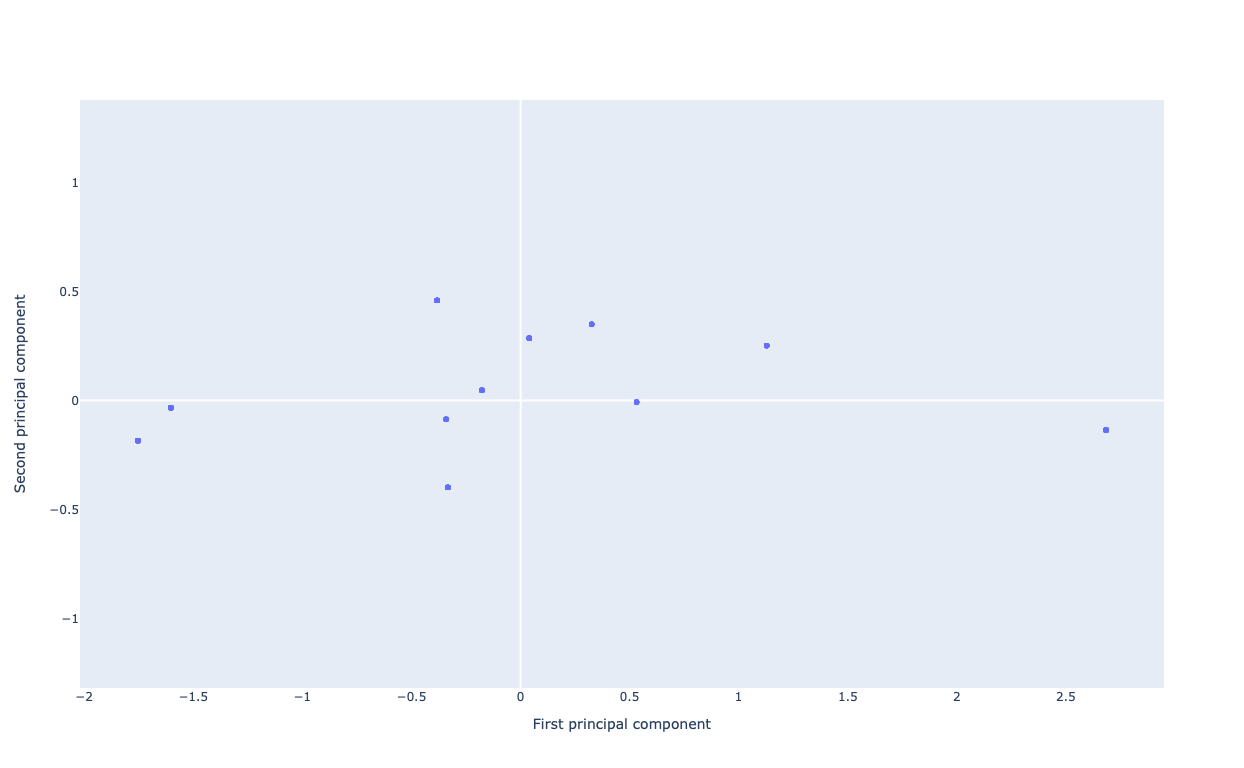

Explained variance ratio: 100.00%


### Explained variance ratio

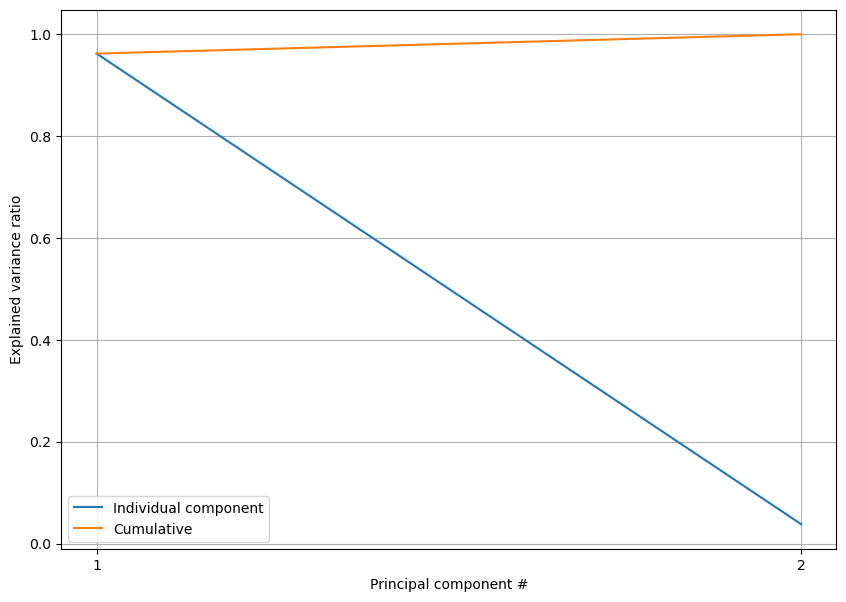

## Parallel coordinates<a id='fc517a23-3541-44c9-bb1a-fc2080993014'>

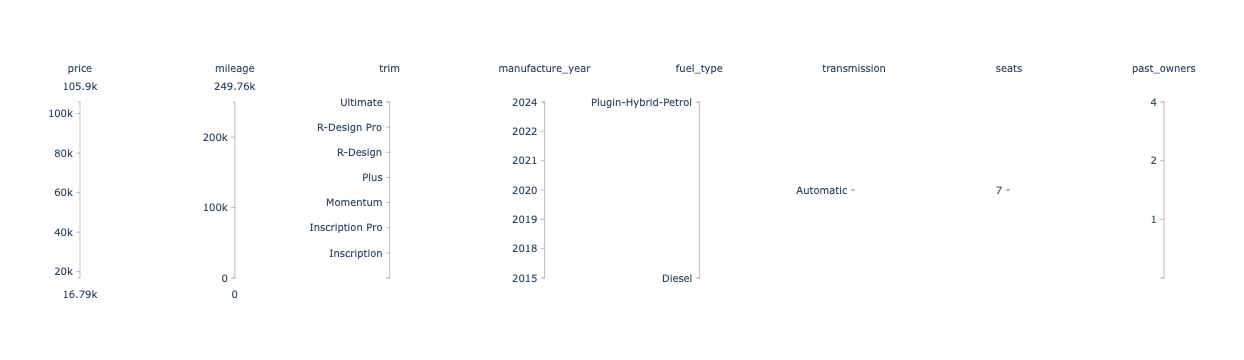

## Parallel categories<a id='824d24b0-2a15-4a1d-a4e8-fd82edf224f9'>

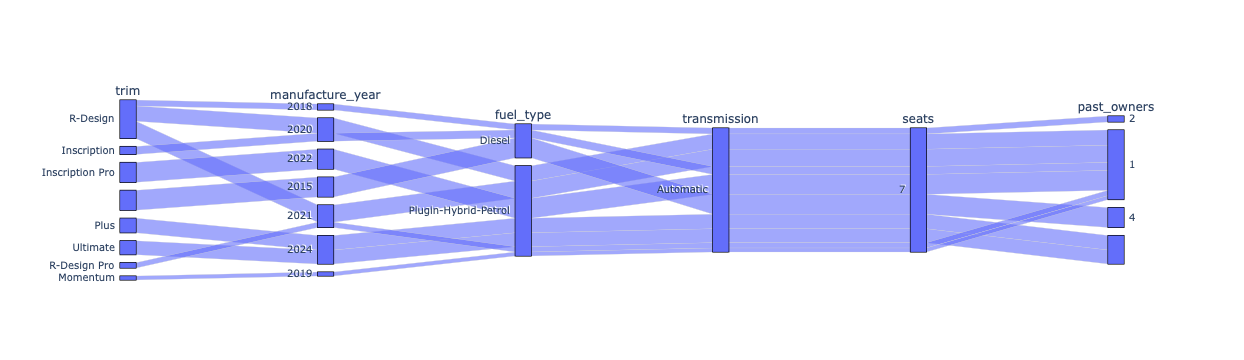

In [53]:
import edvart
edvart.DefaultReport(df).show()

In [78]:
encoders

{'trim': {'zx': 1, 'sx': 2}}